<a href="https://colab.research.google.com/github/vageeshmaiya/Hierarchical-Interpolation/blob/main/An_Interpolation_based_Battery_Data_Forecasting_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Changing directory path

1. Once the drive has been mounted go to the folder icon visible on the left hand side.

2. Click on the drive folder.

3. There find the `datasets` folder.

4. Right click on the folder and select the copy path option.

5. Make sure to copy and paste the path of the folder in the code below.

6. The path of the folder in the code below is: `/content/drive/MyDrive/datasets`

In [2]:
%cd /content/drive/MyDrive/datasets
!ls

/content/drive/MyDrive/datasets
d3_c.csv      dataset3.csv  ETTm2_n.csv		       preprocess_yahoo.py
d3.csv	      dataset4.csv  ETTm2.xlsx		       results
d3_v.csv      ETTh1.csv     men.csv		       test_d3.csv
d3_v.xlsx     ETTh1.xlsx    mendeley.csv	       trial.csv
d3.xlsx       ETTh2.csv     preprocess_electricity.py  Voltage_dataset4.csv
dataset2.csv  ETTm2.csv     preprocess_kpi.py


## Data Preprocessing



In [3]:
# Importing Requirements

import pandas as pd
import numpy as np
from typing import Dict, List, Optional, Tuple, Union
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset

In [4]:
# Loading the dataset csv

y_df = pd.read_csv('dataset3.csv') # Name of the dataset to be used (Can be changed as per requirement)
y_df.head()

,date,Voltage,Current,Charge_Capacity
0,01/27/2018 15:48:09.722,3.402873,0.0,0.0
1,01/27/2018 15:50:09.722,3.403528,0.0,0.0
2,01/27/2018 15:52:09.723,3.403920,0.0,0.0
3,01/27/2018 15:54:09.722,3.404135,0.0,0.0
4,01/27/2018 15:56:09.722,3.404352,0.0,0.0


In [5]:
# Deifining Required classes

class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"

class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5

class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5

class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5

class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5

class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5

class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5

class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5

class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.isocalendar().week - 1) / 52.0 - 0.5

In [6]:
# Defining required functions

def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

In [7]:
# Preprocessing data

y_df['date'] = pd.to_datetime(y_df['date'])
y_df.rename(columns={'date': 'ds'}, inplace=True)
u_ids = y_df.columns.to_list()
u_ids.remove('ds')

time_cls = time_features_from_frequency_str('h')
for cls_ in time_cls:
      cls_name = cls_.__class__.__name__
      y_df[cls_name] = cls_(y_df['ds'].dt)

X_df = y_df.drop(u_ids, axis=1)
y_df = y_df.filter(items=['ds'] + u_ids)
y_df = y_df.set_index('ds').stack()
y_df = y_df.rename('y').rename_axis(['ds', 'unique_id']).reset_index()
y_df['unique_id'] = pd.Categorical(y_df['unique_id'], u_ids)
y_df = y_df[['unique_id', 'ds', 'y']].sort_values(['unique_id', 'ds'])

X_df = y_df[['unique_id', 'ds']].merge(X_df, how='left', on=['ds'])


y_df.head()

,unique_id,ds,y
0,Voltage,2018-01-27 15:48:09.722,3.402873
3,Voltage,2018-01-27 15:50:09.722,3.403528
6,Voltage,2018-01-27 15:52:09.723,3.403920
9,Voltage,2018-01-27 15:54:09.722,3.404135
12,Voltage,2018-01-27 15:56:09.722,3.404352


In [8]:
# Saving the processed data as csv file

y_df.to_csv('test_d3.csv') # Name of the processed dataset can be changed as per requirement

###### The path where the preprocessed dataset is stored canbe found by executing the code below

In [9]:
pwd

'/content/drive/MyDrive/datasets'

## Installing Neuralforecast library

In [10]:
%%capture
pip install git+https://github.com/Nixtla/neuralforecast.git@main

In [11]:
import torch as t
import numpy as np
import pandas as pd
from hyperopt import hp
import matplotlib.pyplot as plt

import neuralforecast as nf
from neuralforecast import auto
from neuralforecast.losses.numpy import mae, mse
from neuralforecast.data.datasets.long_horizon import LongHorizon

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading the data

In [12]:
Y_df = pd.read_csv('/content/drive/MyDrive/datasets/test_d3.csv') # the path of the processed dataset must be changed accordingly
n_time = len(Y_df.ds.unique())
n_ts_val = int(.2 * n_time)
n_ts_test = int(.2 * n_time)
Y_df.head()

,Unnamed: 0,unique_id,ds,y
0,0,Voltage,2018-01-27 15:48:09.722,3.402873
1,3,Voltage,2018-01-27 15:50:09.722,3.403528
2,6,Voltage,2018-01-27 15:52:09.723,3.403920
3,9,Voltage,2018-01-27 15:54:09.722,3.404135
4,12,Voltage,2018-01-27 15:56:09.722,3.404352


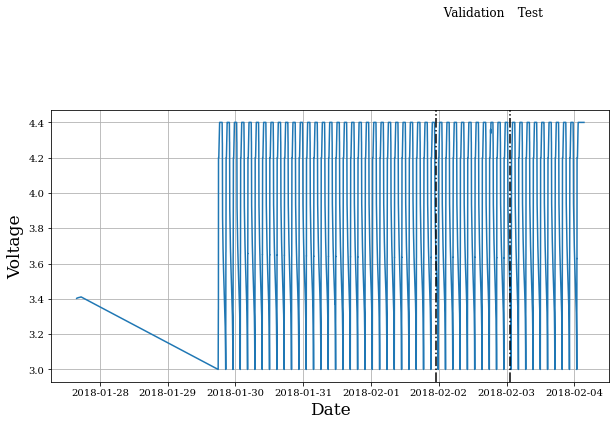

In [13]:
# Plotting the Voltage parameter
# And marking the validation and train split

u_id = 'Voltage'
x_plot = pd.to_datetime(Y_df[Y_df.unique_id==u_id].ds)
y_plot = Y_df[Y_df.unique_id==u_id].y.values

x_val = x_plot[n_time - n_ts_val - n_ts_test]
x_test = x_plot[n_time - n_ts_test]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.xlabel('Date', fontsize=17)
plt.ylabel('Voltage', fontsize=17)

plt.axvline(x_val, color='black', linestyle='-.')
plt.axvline(x_test, color='black', linestyle='-.')
plt.text(x_val, 5, '  Validation', fontsize=12)
plt.text(x_test, 5, '  Test', fontsize=12)

plt.grid()
plt.show()
plt.close()

## Define Hyperparameter Space

The `auto.NHITS` class contains a pre-defined suggested hyperparameter space, built for the Hyperopt library. 

The parameter `n_time_out` is used to specify the desired forecasting horizon.

Refer to http://hyperopt.github.io/hyperopt/ for more information on the different space options, such as lists and continous intervals.

In [14]:
n_time_out = 300 

model = auto.NHITS(n_time_out=300)

In [15]:
model.space['max_steps'] = hp.choice('max_steps', [1000])

## Hyperparameter Tuning

The function `hyperopt_tunning` will perform the automatic hyperparameter optimization using the `Hyperopt` library for any the implemented models, on the specified space, on any dataframes `Y_df` and with custom validation and test losses.

This function will split the data in `Y_df` based on the number of timestamps for the validation and test sets, specified with `ds_in_val` and `ds_in_test`. Each configuration will be trained on the train split, evaluated on the validation and test sets with the desired loss functions.

Use the `hyperopt_max_evals` parameter to change the number of configurations explored (5 is enough for achieving SoTA performance, but more iterations will further improve results).

In [16]:
%%capture
model.fit(Y_df=Y_df, 
          X_df=None,                             # Exogenous variables
          S_df=None,                             # Static variables
          hyperopt_steps=5,                      # Using 5 hyperopt steps
          n_ts_val=n_ts_val,                     # validation set
          n_ts_test=n_ts_test,                   # test set
          results_dir='./results/autonhits',
          save_trials=True,
          loss_function_val=nf.losses.numpy.mae, # MSE, QL, MQL, sMAPE ...
          loss_functions_test={'mae':nf.losses.numpy.mae,
                               'mse':nf.losses.numpy.mse},
          return_test_forecast=True,
          verbose=False)

INFO:hyperopt.tpe:tpe_transform took 0.015052 seconds
INFO:hyperopt.tpe:TPE using 0 trials
INFO:hyperopt.tpe:tpe_transform took 0.023869 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.101004
INFO:hyperopt.tpe:tpe_transform took 0.044202 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.442894
INFO:hyperopt.tpe:tpe_transform took 0.020868 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.442894
INFO:hyperopt.tpe:tpe_transform took 0.022514 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.420155


## Evaluate Results

The `auto.NHITS` contains a `.trials` attribute. For each configuration explored, it will return the validation loss, hyperparameters (model config or `mc` key), run time and test loss.

If the `return_forecasts` flag is set to `True`, the `.trials` attribute will also contain forecasts for the test set.

In [17]:
trials = model.trials
trials.trials[0]['result'].keys()

dict_keys(['loss', 'mc', 'run_time', 'status', 'test_losses', 'forecasts_test'])

We then select the optimal run based on the validation loss, available using `trials.losses()`.

In [18]:
# Best validation hyperparameter configuration

best_run = np.argmin(trials.losses())
print("="*26+' Best  Hyperparameters '+"="*26)
print(pd.Series(trials.trials[best_run]['result']['mc']))

========================== Best  Hyperparameters ==========================
activation                                                ReLU
batch_normalization                                      False
batch_size                                                   1
complete_windows                                          True
constant_n_blocks                                            1
constant_n_layers                                            2
constant_n_mlp_units                                       256
dropout_prob_theta                                           0
early_stop_patience                                         10
eval_freq                                                   50
frequency                                                 None
idx_to_sample_freq                                           1
initialization                                    lecun_normal
interpolation_mode                                      linear
learning_rate                             

Finally, we can retrieve the forecasts for the best run and the true values for the test set.

In [19]:
y_hat = trials.trials[best_run]['result']['forecasts_test']['test_y_hat']
y_true = trials.trials[best_run]['result']['forecasts_test']['test_y_true']

Parsing the predictions and the test windows, for evaluations and plots.

In [20]:
n_windows, n_time_out = y_true.shape
n_series = len(Y_df.unique_id.unique())

print('Raw results')
print('1. y_true.shape (n_windows*n_series, n_time_out):\t', y_true.shape)
print('1. y_hat.shape  (n_windows*n_series, n_time_out):\t', y_hat.shape)

y_hat = y_hat.reshape((n_windows//n_series,n_series,n_time_out))
y_true = y_true.reshape((n_windows//n_series,n_series,n_time_out))

print('Parsed results')
print('2. y_true.shape (n_windows, n_series, n_time_out):\t', y_true.shape)
print('2. y_hat.shape  (n_windows, n_series, n_time_out):\t', y_hat.shape)

Raw results
1. y_true.shape (n_windows*n_series, n_time_out):	 (1578, 300)
1. y_hat.shape  (n_windows*n_series, n_time_out):	 (1578, 300)
Parsed results
2. y_true.shape (n_windows, n_series, n_time_out):	 (526, 3, 300)
2. y_hat.shape  (n_windows, n_series, n_time_out):	 (526, 3, 300)


## Plotting the predictions and Obtaining Error metric values

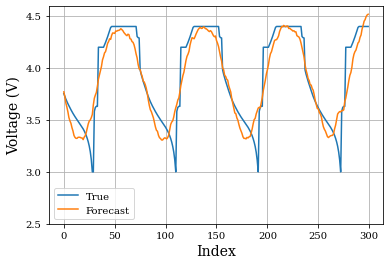

In [25]:
plt.plot(y_true[400,0,:],label='True')
plt.plot(y_hat[400,0,:],label='Forecast')
plt.yticks([2.5,3,3.5,4,4.5]) # Can be varied as per parameter
plt.grid()
plt.ylabel('Voltage (V)',fontsize=14)
plt.xlabel('Index', fontsize=14)
plt.legend()
#plt.savefig('cc_men_horizon_500.pdf',bbox_inches='tight')
plt.show()
plt.close()

To find the path where the plots are stored run the code line below

In [36]:
pwd

'/content/drive/MyDrive/datasets'

In [26]:
print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))

MAE:  0.3567074
MSE:  0.5157907


## Getting error values for different horizons

In [30]:
%%capture
with open("results.csv", 'w') as wl:
  write_str = "horizon,mae,mse" + '\n'
  wl.write(write_str)
  for i in [24,48,96,168,288,408]: # Horizon values (Can be changed as per requirement)
    Y_df = pd.read_csv('/content/drive/MyDrive/datasets/test_d3.csv')
    
    n_time = len(Y_df.ds.unique())
    n_ts_val = int(.2 * n_time)
    n_ts_test = int(.2 * n_time)

    n_time_out = i 

    model = auto.NHITS(n_time_out=i)
    model.space['max_steps'] = hp.choice('max_steps', [1000])


    model.fit(Y_df=Y_df, 
              X_df=None,                             
              S_df=None,                             
              hyperopt_steps=5,                      
              n_ts_val=n_ts_val,                     
              n_ts_test=n_ts_test,                   
              results_dir='./results/autonhits',
              save_trials=True,
              loss_function_val=nf.losses.numpy.mae,
              loss_functions_test={'mae':nf.losses.numpy.mae,
                                  'mse':nf.losses.numpy.mse},
              return_test_forecast=True,
              verbose=False)
    
    trials = model.trials
    trials.trials[0]['result'].keys()

    best_run = np.argmin(trials.losses())
    print("="*26+' Best  Hyperparameters '+"="*26)
    print(pd.Series(trials.trials[best_run]['result']['mc']))

    y_hat = trials.trials[best_run]['result']['forecasts_test']['test_y_hat']
    y_true = trials.trials[best_run]['result']['forecasts_test']['test_y_true']

    n_windows, n_time_out = y_true.shape
    n_series = len(Y_df.unique_id.unique())

    print('Raw results')
    print('1. y_true.shape (n_windows*n_series, n_time_out):\t', y_true.shape)
    print('1. y_hat.shape  (n_windows*n_series, n_time_out):\t', y_hat.shape)

    y_hat = y_hat.reshape((n_windows//n_series,n_series,n_time_out))
    y_true = y_true.reshape((n_windows//n_series,n_series,n_time_out))

    print('Parsed results')
    print('2. y_true.shape (n_windows, n_series, n_time_out):\t', y_true.shape)
    print('2. y_hat.shape  (n_windows, n_series, n_time_out):\t', y_hat.shape)

    w = str(i) + ',' + str(mae(y_hat, y_true)) + ',' + str(mse(y_hat, y_true)) + '\n'
    wl.write(w)


INFO:hyperopt.tpe:tpe_transform took 0.032751 seconds
INFO:hyperopt.tpe:TPE using 0 trials
INFO:hyperopt.tpe:tpe_transform took 0.030876 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.232410
INFO:hyperopt.tpe:tpe_transform took 0.030609 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.232410
INFO:hyperopt.tpe:tpe_transform took 0.017015 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.186943
INFO:hyperopt.tpe:tpe_transform took 0.026391 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.134873
INFO:hyperopt.tpe:tpe_transform took 0.018676 seconds
INFO:hyperopt.tpe:TPE using 0 trials
INFO:hyperopt.tpe:tpe_transform took 0.016942 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.252538
INFO:hyperopt.tpe:tpe_transform took 0.036184 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.217585
INFO:hyperopt.tpe:tpe_transform took 0.024514 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.198915

In [32]:
df = pd.read_csv('/content/drive/MyDrive/datasets/results.csv')
df

,horizon,mae,mse
0,24,0.132929,0.132007
1,48,0.178558,0.170440
2,96,0.200108,0.207271
3,168,0.243703,0.278428
4,288,0.388648,0.554785
5,408,0.733145,1.686926


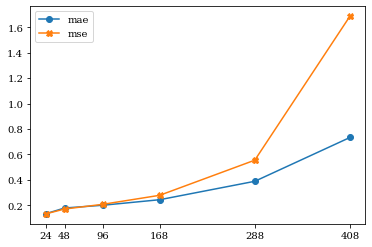

In [35]:
# Plotting the error metrics

plt.plot(df['horizon'],df['mae'],marker='o',label="mae")
plt.plot(df['horizon'],df['mse'],marker='X',label="mse")
plt.xticks(df['horizon'])
plt.legend()
#plt.savefig('error_plot.pdf',bbox-inches='tight')